# Representation Jensen-Rényi Divergence Variational Autoencoder
This experiment compares with an Maximum Mean Discrepancy Variational Autoencoder introduced in 

Zhao, S., Song, J., & Ermon, S. (2017). InfoVAE: Information Maximizing Variational Autoencoders. ArXiv, abs/1706.02262.

The code below is based on https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder/blob/master/mmd_vae.ipynb



In [1]:
import torch
from torch.autograd import Variable

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

import numpy as np
from matplotlib import pyplot as plt
import math, os
import sys

import repitl.kernel_utils as ku
import repitl.matrix_itl as itl
import repitl.divergences as div

In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [3]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x

In [4]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x[:,None,:] # (x_size, 1, dim)
    y = y[None, :,:] # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(-1)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

def matrixJRDivergence(x, y):
    alpha = 1.01
    sigma = np.sqrt(x.shape[1]/2)
    
    return div.divergenceJR(x, y, sigma, alpha)

In [5]:
class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [6]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples


def trainInfoVAE(
    dataloader,
    divergence_func=compute_mmd,
    tradeoff=1.0,
    z_dim=2,
    n_epochs=10,
    use_cuda=True,
    print_every=100,
    plot_every=500
):
    model = Model(z_dim)
    if use_cuda:
        model = model.cuda()
    #print(model)
    optimizer = torch.optim.Adam(model.parameters())
    i = -1
    for epoch in range(n_epochs):
        for images, labels in dataloader:
            i += 1
            optimizer.zero_grad()
            x = Variable(images, requires_grad=False)
            true_samples = Variable(
                torch.randn(200, z_dim),
                requires_grad=False
            )
            if use_cuda:
                x = x.cuda()
                true_samples = true_samples.cuda()
            z, x_reconstructed = model(x)
            div = divergence_func(true_samples, z)
            nll = (x_reconstructed - x).pow(2).mean()
            loss = nll + tradeoff * div
            loss.backward()
            optimizer.step()
            if i % print_every == 0:
                print("Negative log likelihood is {:.5f}, divergence loss is {:.5f}".format(
                    nll.item(), div.item()))
            if i % plot_every == 0:
                gen_z = Variable(
                    torch.randn(100, z_dim),
                    requires_grad=False
                )
                if use_cuda:
                    gen_z = gen_z.cuda()
                samples = model.decoder(gen_z)
                samples = samples.permute(0,2,3,1).contiguous().cpu().data.numpy()
                plt.imshow(convert_to_display(samples), cmap='Greys_r')
                plt.show()
                
    return model

## Train on MNIST

In [7]:
batch_size=200
mnist_train = torch.utils.data.DataLoader(
    MNIST("./tmp/MNIST", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, num_workers=3,
    pin_memory=True
)

Negative log likelihood is 0.26192, divergence loss is 0.01104


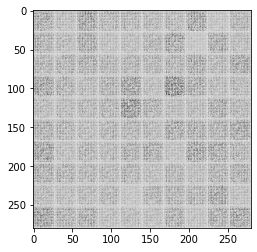

Negative log likelihood is 0.05838, divergence loss is 0.00694
Negative log likelihood is 0.03193, divergence loss is 0.00277
Negative log likelihood is 0.02498, divergence loss is 0.00257
Negative log likelihood is 0.02111, divergence loss is 0.00234
Negative log likelihood is 0.01760, divergence loss is 0.00376


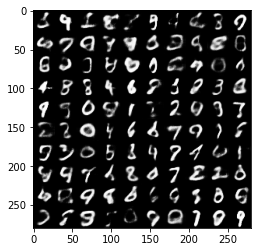

Negative log likelihood is 0.01874, divergence loss is 0.00509
Negative log likelihood is 0.01791, divergence loss is 0.00102
Negative log likelihood is 0.01522, divergence loss is 0.00182
Negative log likelihood is 0.01466, divergence loss is 0.00201
Negative log likelihood is 0.01400, divergence loss is 0.00118


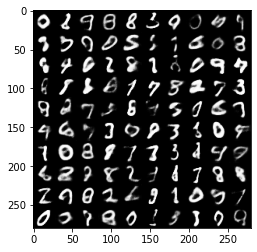

Negative log likelihood is 0.01426, divergence loss is 0.00232
Negative log likelihood is 0.01376, divergence loss is 0.00240
Negative log likelihood is 0.01327, divergence loss is 0.00215
Negative log likelihood is 0.01305, divergence loss is 0.00250
Negative log likelihood is 0.01276, divergence loss is 0.00102


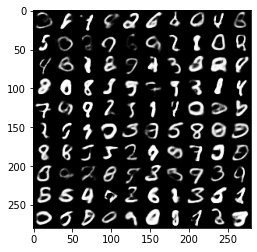

Negative log likelihood is 0.01199, divergence loss is 0.00171
Negative log likelihood is 0.01307, divergence loss is 0.00256
Negative log likelihood is 0.01108, divergence loss is 0.00163
Negative log likelihood is 0.01148, divergence loss is 0.00176
Negative log likelihood is 0.01257, divergence loss is 0.00116


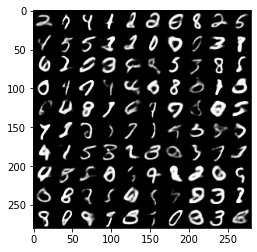

Negative log likelihood is 0.01184, divergence loss is 0.00160
Negative log likelihood is 0.01164, divergence loss is 0.00310
Negative log likelihood is 0.01123, divergence loss is 0.00298
Negative log likelihood is 0.01065, divergence loss is 0.00089
Negative log likelihood is 0.01108, divergence loss is 0.00262


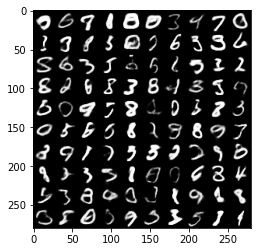

Negative log likelihood is 0.01057, divergence loss is 0.00194
Negative log likelihood is 0.00995, divergence loss is 0.00207
Negative log likelihood is 0.01099, divergence loss is 0.00275
Negative log likelihood is 0.00993, divergence loss is 0.00303
Negative log likelihood is 0.01038, divergence loss is 0.00241


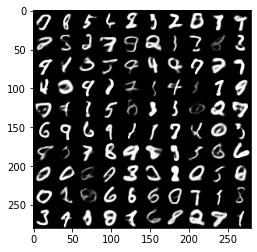

Negative log likelihood is 0.01062, divergence loss is 0.00108
Negative log likelihood is 0.00978, divergence loss is 0.00246
Negative log likelihood is 0.01018, divergence loss is 0.00104
Negative log likelihood is 0.01020, divergence loss is 0.00398
Negative log likelihood is 0.01020, divergence loss is 0.00304


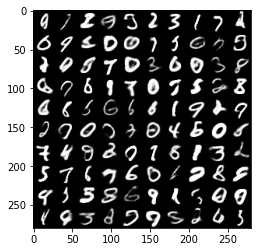

Negative log likelihood is 0.00995, divergence loss is 0.00360
Negative log likelihood is 0.01022, divergence loss is 0.00169
Negative log likelihood is 0.01023, divergence loss is 0.00218
Negative log likelihood is 0.00978, divergence loss is 0.00279
Negative log likelihood is 0.01058, divergence loss is 0.00083


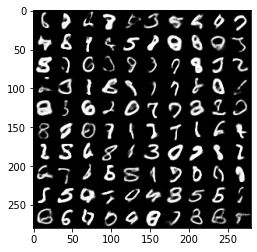

Negative log likelihood is 0.00961, divergence loss is 0.00073
Negative log likelihood is 0.00967, divergence loss is 0.00405
Negative log likelihood is 0.01003, divergence loss is 0.00246
Negative log likelihood is 0.01041, divergence loss is 0.00218
Negative log likelihood is 0.00987, divergence loss is 0.00158


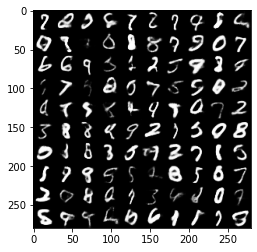

Negative log likelihood is 0.00915, divergence loss is 0.00170
Negative log likelihood is 0.00959, divergence loss is 0.00231
Negative log likelihood is 0.00915, divergence loss is 0.00144
Negative log likelihood is 0.00949, divergence loss is 0.00199
Negative log likelihood is 0.00927, divergence loss is 0.00180


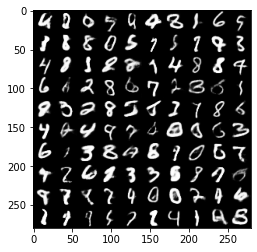

Negative log likelihood is 0.00877, divergence loss is 0.00106
Negative log likelihood is 0.00915, divergence loss is 0.00085
Negative log likelihood is 0.00851, divergence loss is 0.00257
Negative log likelihood is 0.00932, divergence loss is 0.00168
Negative log likelihood is 0.00942, divergence loss is 0.00441


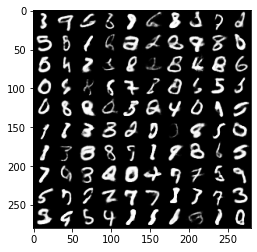

Negative log likelihood is 0.00940, divergence loss is 0.00120
Negative log likelihood is 0.00864, divergence loss is 0.00219
Negative log likelihood is 0.00971, divergence loss is 0.00189
Negative log likelihood is 0.00888, divergence loss is 0.00157


In [8]:
# train MMD Baseline
z_dim = 10
mmd_model = trainInfoVAE(mnist_train, 
                         z_dim=z_dim, 
                         n_epochs=20)

Negative log likelihood is 0.23971, divergence loss is 0.48181


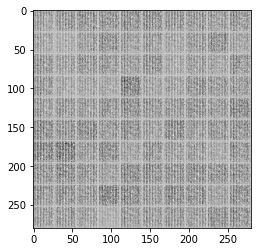

Negative log likelihood is 0.02423, divergence loss is 0.24158
Negative log likelihood is 0.01986, divergence loss is 0.21740
Negative log likelihood is 0.01686, divergence loss is 0.23892
Negative log likelihood is 0.01586, divergence loss is 0.20942
Negative log likelihood is 0.01446, divergence loss is 0.22995


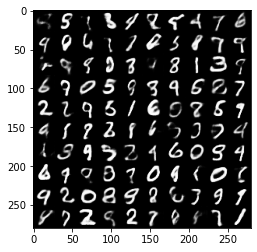

Negative log likelihood is 0.01564, divergence loss is 0.22446
Negative log likelihood is 0.01358, divergence loss is 0.20680
Negative log likelihood is 0.01422, divergence loss is 0.21665
Negative log likelihood is 0.01318, divergence loss is 0.21058
Negative log likelihood is 0.01183, divergence loss is 0.20821


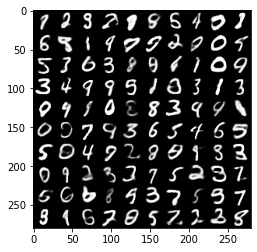

Negative log likelihood is 0.01211, divergence loss is 0.22164
Negative log likelihood is 0.01327, divergence loss is 0.20610
Negative log likelihood is 0.01161, divergence loss is 0.20888
Negative log likelihood is 0.01193, divergence loss is 0.21530
Negative log likelihood is 0.01219, divergence loss is 0.20310


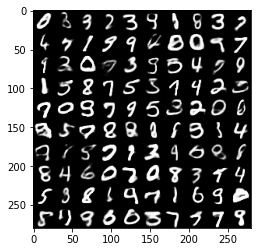

Negative log likelihood is 0.01173, divergence loss is 0.21160
Negative log likelihood is 0.01064, divergence loss is 0.20946
Negative log likelihood is 0.01122, divergence loss is 0.21798
Negative log likelihood is 0.01018, divergence loss is 0.21373
Negative log likelihood is 0.01066, divergence loss is 0.21173


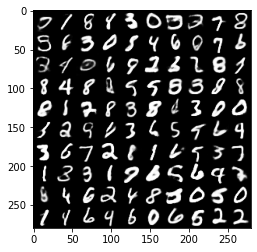

Negative log likelihood is 0.01058, divergence loss is 0.19791
Negative log likelihood is 0.01022, divergence loss is 0.20570
Negative log likelihood is 0.01171, divergence loss is 0.20857
Negative log likelihood is 0.01075, divergence loss is 0.20201
Negative log likelihood is 0.00953, divergence loss is 0.20910


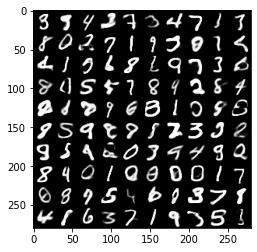

Negative log likelihood is 0.00992, divergence loss is 0.20096
Negative log likelihood is 0.00961, divergence loss is 0.20718
Negative log likelihood is 0.00943, divergence loss is 0.19266
Negative log likelihood is 0.01045, divergence loss is 0.19760
Negative log likelihood is 0.00990, divergence loss is 0.21404


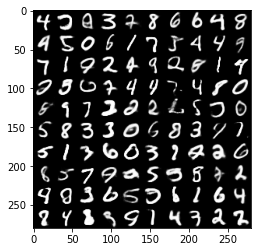

Negative log likelihood is 0.00948, divergence loss is 0.19710
Negative log likelihood is 0.00897, divergence loss is 0.21629
Negative log likelihood is 0.00963, divergence loss is 0.20379
Negative log likelihood is 0.00942, divergence loss is 0.20046
Negative log likelihood is 0.00958, divergence loss is 0.20058


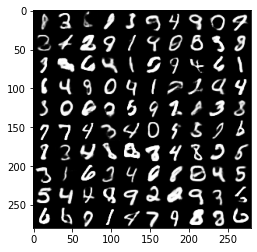

Negative log likelihood is 0.00944, divergence loss is 0.20444
Negative log likelihood is 0.00919, divergence loss is 0.20831
Negative log likelihood is 0.00821, divergence loss is 0.19896
Negative log likelihood is 0.00928, divergence loss is 0.22197
Negative log likelihood is 0.00933, divergence loss is 0.19728


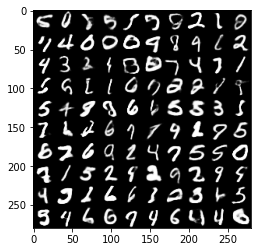

Negative log likelihood is 0.00959, divergence loss is 0.21485
Negative log likelihood is 0.00890, divergence loss is 0.21194
Negative log likelihood is 0.00902, divergence loss is 0.20249
Negative log likelihood is 0.00961, divergence loss is 0.20782
Negative log likelihood is 0.00900, divergence loss is 0.21376


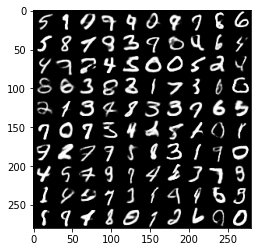

Negative log likelihood is 0.00976, divergence loss is 0.20526
Negative log likelihood is 0.00831, divergence loss is 0.20613
Negative log likelihood is 0.00864, divergence loss is 0.20634
Negative log likelihood is 0.00993, divergence loss is 0.20371
Negative log likelihood is 0.00851, divergence loss is 0.21282


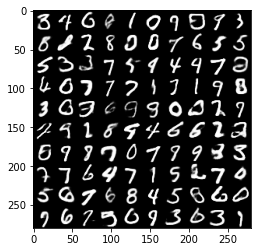

Negative log likelihood is 0.00826, divergence loss is 0.20317
Negative log likelihood is 0.00865, divergence loss is 0.19958
Negative log likelihood is 0.00924, divergence loss is 0.20645
Negative log likelihood is 0.00787, divergence loss is 0.21743
Negative log likelihood is 0.00915, divergence loss is 0.20624


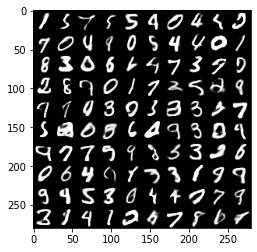

Negative log likelihood is 0.00849, divergence loss is 0.20098
Negative log likelihood is 0.00870, divergence loss is 0.19649
Negative log likelihood is 0.00859, divergence loss is 0.18526
Negative log likelihood is 0.00896, divergence loss is 0.21577


In [9]:
jrd_model = trainInfoVAE(mnist_train, 
                         divergence_func=matrixJRDivergence, 
                         tradeoff=0.1,
                         z_dim=z_dim, 
                         n_epochs=20)

In [10]:
## gather train data to train svm 
def gatherMNISTData(model):
    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        MNIST("./tmp/MNIST", train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(100):
        batch_x, batch_y = iter(mnist_test).next()
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z_train = np.concatenate(z_list, axis=0)
    label_train = np.concatenate(label_list)

    ## gather test data

    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        MNIST("./tmp/MNIST", train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(20):
        batch_x, batch_y = iter(mnist_test).next()
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z_test = np.concatenate(z_list, axis=0)
    label_test = np.concatenate(label_list)
    return (z_train, label_train), (z_test, label_test)

In [19]:
mmd_train_data, mmd_test_data = gatherMNISTData(mmd_model)

jrd_train_data, jrd_test_data = gatherMNISTData(jrd_model)


In [20]:
## train an svm classifier
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def testClassifier(train_data, test_data):
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(train_data[0], train_data[1])

    pred_label = clf.predict(test_data[0])
    acc = np.mean(pred_label == test_data[1])

    print('test accuracy {: 5f}'.format(acc))

In [21]:
testClassifier(mmd_train_data, mmd_test_data)

test accuracy  0.978400


In [22]:
testClassifier(jrd_train_data, jrd_test_data)

test accuracy  0.980500
